In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import random
from prophet import Prophet

/Users/finneyer/anaconda3/envs/DSPRO/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_dir = os.path.join(os.getcwd(), '../../model')
sys.path.append(file_dir)
import prophet_model as pm
import model_functions as mf

### Set paths of Train and Test data

In [3]:
train_data_path = '/Users/finneyer/Documents/HSLU/Semester 3/DSPRO1/Projektarbeit/Data/Day/10_fixed/London_UTD19_train_Day_0.csv' # Insert train data path
test_data_path = '/Users/finneyer/Documents/HSLU/Semester 3/DSPRO1/Projektarbeit/Data/Day/10_fixed/London_UTD19_test_Day_0.csv' # Insert test data path

### Only choose the data of one detector

In [4]:
train_data = pd.read_csv(train_data_path)
train_data = train_data.drop(columns=['long', 'lat', 'pos', 'length','fclass'], axis = 1)
test_data = pd.read_csv(test_data_path)
test_data = test_data.drop(columns=['long', 'lat', 'pos', 'length','fclass'], axis = 1)

In [5]:
detector_id = train_data.detid.unique()[284]
train_data_det = train_data[train_data['detid'] == detector_id]
test_data_det = test_data[test_data['detid'] == detector_id]

### Transform data to be able to use it with Meta Prophet

In [6]:
train_data_det_cp = train_data_det.copy()
train_data_det_enc, le = pm.label_encode_categorical(train_data_det_cp, 'detid')
train_data_det_enc = mf.unfold_weekday_to_interval(train_data_det_enc)
train_data_det_enc = pm.interval_to_datetime(train_data_det_enc, 'interval')
train_data_det_enc = train_data_det_enc.rename(columns={'traffic' : 'y', 'datetime' : 'ds'})

test_data_det_cp = test_data_det.copy()
test_data_det_enc, le = pm.label_encode_categorical(test_data_det_cp, 'detid')
test_data_det_enc = mf.unfold_weekday_to_interval(test_data_det_enc)
test_data_det_enc = pm.interval_to_datetime(test_data_det_enc, 'interval')
test_data_det_enc = test_data_det_enc.rename(columns={'traffic' : 'y', 'datetime' : 'ds'})

### Plot train and test data

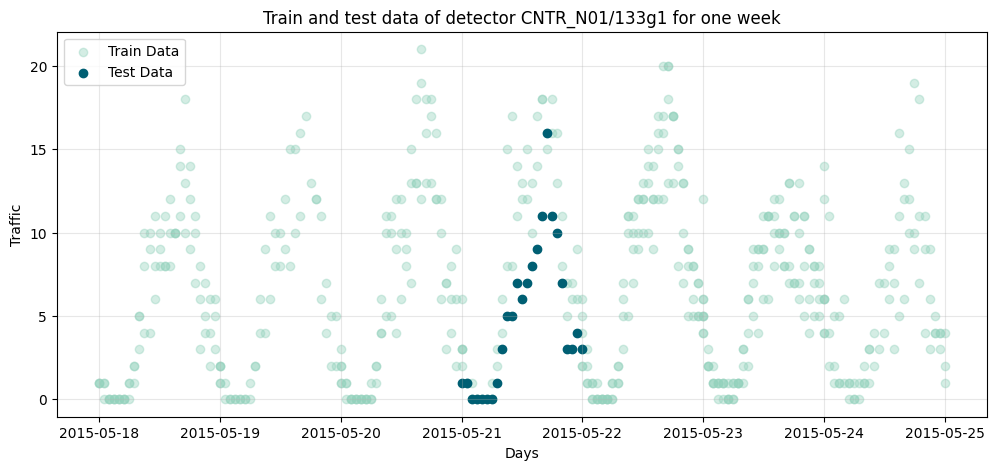

In [39]:
plt.figure(figsize=(12, 5))
plt.title(f'Train and test data of detector {detector_id} for one week')
plt.scatter(train_data_det_enc.ds, train_data_det_enc.y, color="#94D2BD", alpha=0.4, label="Train Data") 
plt.scatter(test_data_det_enc.ds, test_data_det_enc.y, color="#005F73", alpha=1, label="Test Data")
plt.xlabel("Days")  
plt.ylabel("Traffic") 
plt.grid(True, alpha=0.3)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1]
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left')

### Prepare and train Meta Prophet model
Test the behavior of different values for the paramter changepoint_prior_scale

In [8]:
from datetime import timedelta

In [32]:
def train_forecast_plot_prophet(changepoint_prior_scale):
    if changepoint_prior_scale == 0.05:
        std_string = '(default)'
    else:
        std_string = ''
    
    # Create and train model
    model = Prophet(changepoint_prior_scale=changepoint_prior_scale)
    model.fit(train_data_det_enc[['ds', 'y']])
    
    # Forecast future data
    future = test_data_det_enc[['ds']]
    forecast = model.predict(future)
    
    # Check Timespan of test data
    start_date = forecast.ds.min()
    end_date = start_date + timedelta(days=1)
    train_data_date = train_data_det_enc[train_data_det_enc['ds'].between(start_date, end_date)]
    
    # Plot results with train data test data
    plt.figure(figsize=(10, 4))
    plt.title(f'Train and prediction data of detector {detector_id} with changepoint_prior_scale={changepoint_prior_scale} {std_string}')
    plt.scatter(train_data_date.ds, train_data_date.y, color="#94D2BD", alpha=0.4, label="Train data") 
    plt.scatter(forecast.ds, forecast.yhat, color="#AE2012", alpha=0.4, label="Predictions") 

    plt.xlabel("Timestamp")  
    plt.ylabel("Traffic") 
    plt.grid(True, alpha=0.3)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,1]
    plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left')

### Evaluate results visually

16:53:59 - cmdstanpy - INFO - Chain [1] start processing


16:53:59 - cmdstanpy - INFO - Chain [1] done processing


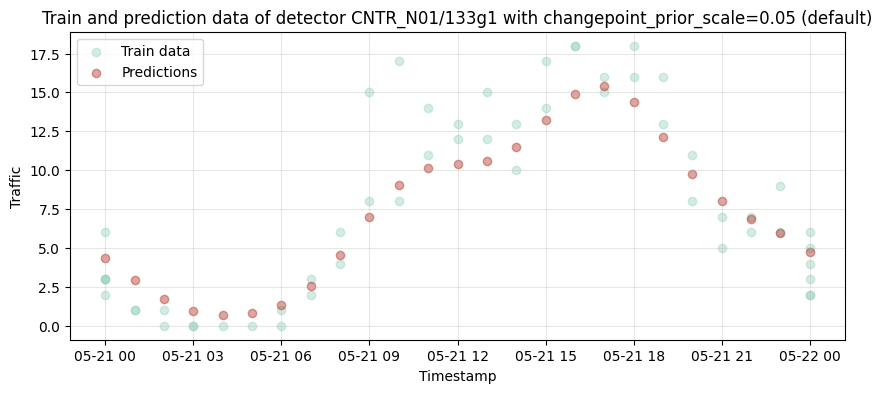

In [33]:
train_forecast_plot_prophet(0.05) # Default

16:54:00 - cmdstanpy - INFO - Chain [1] start processing
16:54:00 - cmdstanpy - INFO - Chain [1] done processing


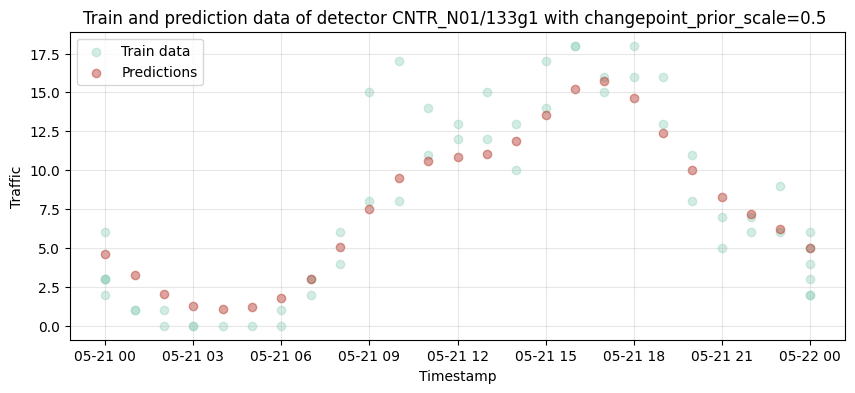

In [34]:
train_forecast_plot_prophet(0.5)

16:54:00 - cmdstanpy - INFO - Chain [1] start processing
16:54:00 - cmdstanpy - INFO - Chain [1] done processing


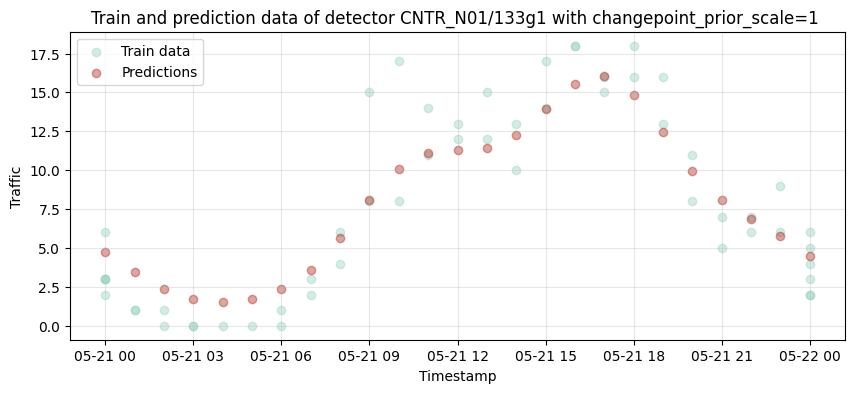

In [35]:
train_forecast_plot_prophet(1)

16:54:46 - cmdstanpy - INFO - Chain [1] start processing
16:54:46 - cmdstanpy - INFO - Chain [1] done processing


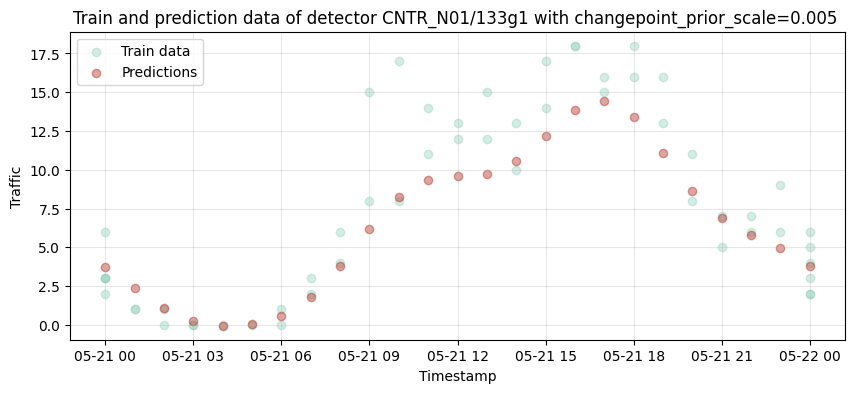

In [37]:
train_forecast_plot_prophet(0.005)

16:54:46 - cmdstanpy - INFO - Chain [1] start processing
16:54:46 - cmdstanpy - INFO - Chain [1] done processing


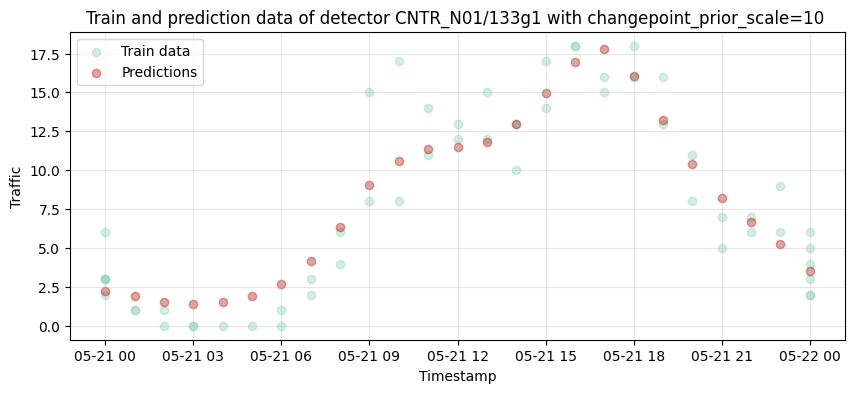

In [38]:
train_forecast_plot_prophet(10)